# 🤖 Notebook 03 — Model Training, Tuning & Comparison

Train Logistic Regression, RandomForest, and XGBoost; perform hyperparameter
tuning and full evaluation (ROC/PR, confusion matrices, business-cost
thresholding).

In [1]:
# === CELL 1: Setup ===
import sys
import json
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
METRICS_DIR = PROJECT_ROOT / "reports" / "metrics"
MODELS_DIR = PROJECT_ROOT / "models" / "production"
for d in [FIGURES_DIR, METRICS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete")

✅ Setup complete


In [2]:
# === CELL 2: Load Data ===
from src.data.ingest import load_raw_data
from src.data.clean import clean_pipeline
from src.data.split import stratified_split
from src.features.build_features import build_full_pipeline, TARGET

df = load_raw_data()
df = clean_pipeline(df, production=True)
df_train, df_val, df_test = stratified_split(df)

X_train, y_train = df_train.drop(columns=[TARGET]), df_train[TARGET]
X_val, y_val = df_val.drop(columns=[TARGET]), df_val[TARGET]
X_test, y_test = df_test.drop(columns=[TARGET]), df_test[TARGET]

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"Positive rates — Train: {y_train.mean():.3f} | Val: {y_val.mean():.3f} | Test: {y_test.mean():.3f}")

Train: (28831, 19) | Val: (6178, 19) | Test: (6179, 19)
Positive rates — Train: 0.113 | Val: 0.113 | Test: 0.113


In [3]:
# === CELL 3: Define Models ===
RANDOM_STATE = 42

models_config = {
    "Logistic Regression": {
        "model": LogisticRegression(
            C=1.0, penalty="l2", solver="saga", max_iter=2000,
            class_weight="balanced", random_state=RANDOM_STATE,
        ),
        "description": "Linear baseline. Interpretable coefficients. L2 regularization.",
    },
    "Random Forest": {
        "model": RandomForestClassifier(
            n_estimators=400, max_depth=12, min_samples_split=10,
            min_samples_leaf=5, class_weight="balanced",
            random_state=RANDOM_STATE, n_jobs=-1,
        ),
        "description": "Ensemble of decorrelated trees. Robust, low tuning effort.",
    },
    "XGBoost": {
        "model": XGBClassifier(
            n_estimators=500, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.1, reg_lambda=1.0,
            scale_pos_weight=7.9,  # ~ratio of neg/pos
            eval_metric="aucpr",
            random_state=RANDOM_STATE, n_jobs=-1,
        ),
        "description": "Gradient-boosted trees. Usually best for tabular data.",
    },
}

5-FOLD STRATIFIED CROSS-VALIDATION

Logistic Regression:
  ROC-AUC: 0.7877 ± 0.0110
  PR-AUC:  0.4393 ± 0.0214
  F1:      0.4468 ± 0.0152

Random Forest:
  ROC-AUC: 0.7974 ± 0.0131
  PR-AUC:  0.4609 ± 0.0228
  F1:      0.4864 ± 0.0177

XGBoost:
  ROC-AUC: 0.7787 ± 0.0151
  PR-AUC:  0.4362 ± 0.0278
  F1:      0.4509 ± 0.0117


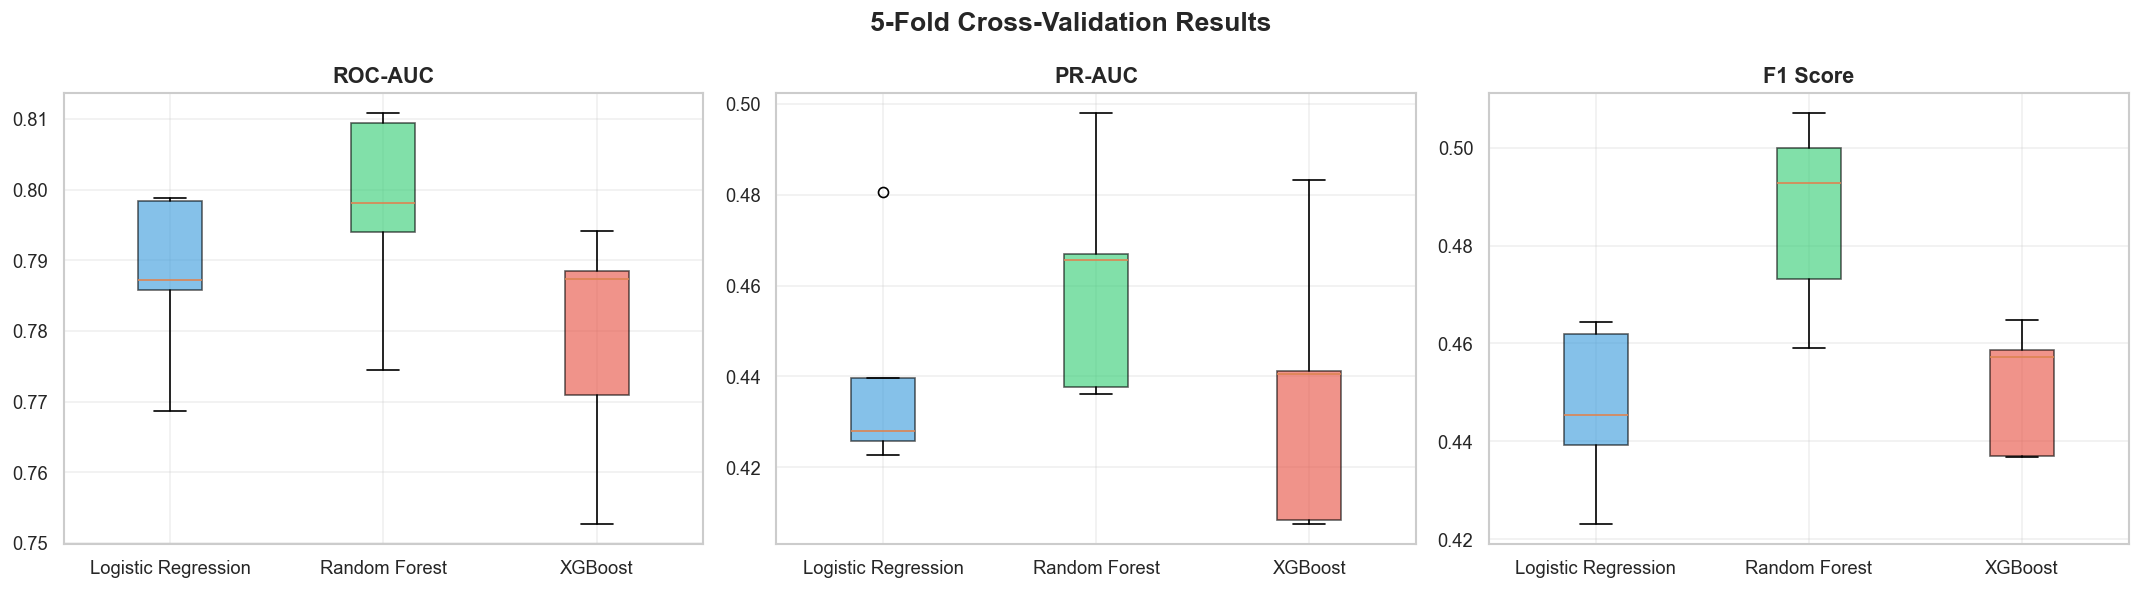

In [4]:
# === CELL 4: Cross-Validation Comparison ===
print("=" * 60)
print("5-FOLD STRATIFIED CROSS-VALIDATION")
print("=" * 60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = {}
for name, config in models_config.items():
    pipeline = build_full_pipeline(config["model"])

    auc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    pr_auc_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="average_precision", n_jobs=-1)

    cv_results[name] = {
        "roc_auc": auc_scores,
        "f1": f1_scores,
        "pr_auc": pr_auc_scores,
    }

    print(f"\n{name}:")
    print(f"  ROC-AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
    print(f"  PR-AUC:  {pr_auc_scores.mean():.4f} ± {pr_auc_scores.std():.4f}")
    print(f"  F1:      {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")

# Visualize CV results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics_to_plot = ["roc_auc", "pr_auc", "f1"]
titles = ["ROC-AUC", "PR-AUC", "F1 Score"]

for ax, metric, title in zip(axes, metrics_to_plot, titles):
    data = [cv_results[name][metric] for name in models_config]
    bp = ax.boxplot(data, labels=list(models_config.keys()), patch_artist=True)
    colors = ["#3498db", "#2ecc71", "#e74c3c"]
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(True, alpha=0.3)

plt.suptitle("5-Fold Cross-Validation Results", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cv_comparison.png", bbox_inches="tight")
plt.show()

In [5]:
# === CELL 5: Train Final Models on Full Training Set ===
print("=" * 60)
print("TRAINING FINAL MODELS")
print("=" * 60)

trained_pipelines = {}
for name, config in models_config.items():
    pipeline = build_full_pipeline(config["model"])
    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    print(f"✅ {name} trained")

TRAINING FINAL MODELS
✅ Logistic Regression trained
✅ Random Forest trained
✅ XGBoost trained


COST-OPTIMAL THRESHOLD SEARCH (on validation set)
Cost model: FP=$5 (wasted call) | FN=$200 (missed conversion) | TP=$195 (net)

Logistic Regression:
  Optimal threshold: 0.100
  Max validation profit: $108,355

Random Forest:
  Optimal threshold: 0.118
  Max validation profit: $108,505

XGBoost:
  Optimal threshold: 0.050
  Max validation profit: $104,845


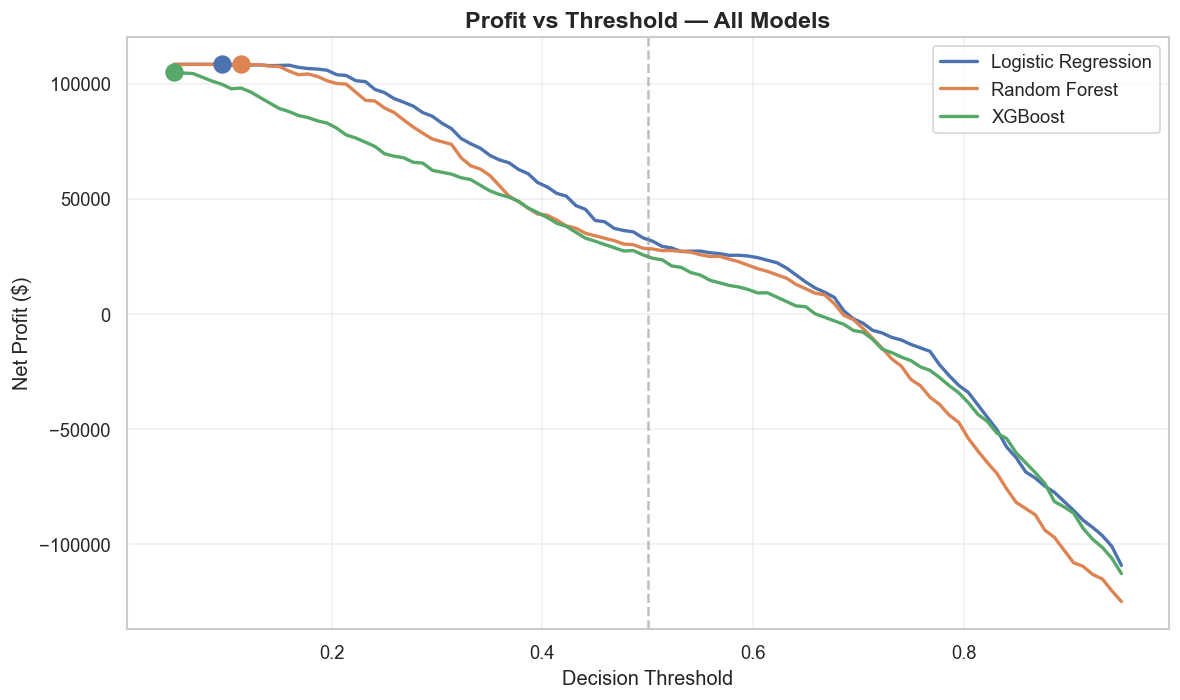

In [6]:
# === CELL 6: Cost-Optimal Threshold Search ===
from src.evaluation.threshold import find_optimal_threshold

print("=" * 60)
print("COST-OPTIMAL THRESHOLD SEARCH (on validation set)")
print("=" * 60)
print("Cost model: FP=$5 (wasted call) | FN=$200 (missed conversion) | TP=$195 (net)")

thresholds = {}
for name, pipeline in trained_pipelines.items():
    y_val_prob = pipeline.predict_proba(X_val)[:, 1]
    opt_threshold, opt_profit = find_optimal_threshold(y_val, y_val_prob)
    thresholds[name] = opt_threshold
    print(f"\n{name}:")
    print(f"  Optimal threshold: {opt_threshold:.3f}")
    print(f"  Max validation profit: ${opt_profit:,.0f}")

# Threshold sensitivity analysis for best model
fig, ax = plt.subplots(figsize=(10, 6))
for name, pipeline in trained_pipelines.items():
    y_val_prob = pipeline.predict_proba(X_val)[:, 1]
    profits = []
    thresh_range = np.linspace(0.05, 0.95, 100)
    for t in thresh_range:
        y_pred = (y_val_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        profit = tp * 195 - fp * 5 - fn * 200
        profits.append(profit)
    ax.plot(thresh_range, profits, linewidth=2, label=name)
    opt_idx = np.argmax(profits)
    ax.scatter(thresh_range[opt_idx], profits[opt_idx], s=100, zorder=5)

ax.set_xlabel("Decision Threshold", fontsize=12)
ax.set_ylabel("Net Profit ($)", fontsize=12)
ax.set_title("Profit vs Threshold — All Models", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.axvline(0.5, color="gray", linestyle="--", alpha=0.5, label="Default 0.5")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "threshold_sensitivity.png", bbox_inches="tight")
plt.show()

In [7]:
# === CELL 7: Full Evaluation on Test Set ===
from src.evaluation.metrics import compute_all_metrics, business_cost_analysis

print("=" * 60)
print("TEST SET EVALUATION (using cost-optimal thresholds)")
print("=" * 60)

all_results = []
test_predictions = {}

for name, pipeline in trained_pipelines.items():
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]
    opt_t = thresholds[name]
    y_test_pred = (y_test_prob >= opt_t).astype(int)

    metrics = compute_all_metrics(y_test, y_test_pred, y_test_prob)
    cost = business_cost_analysis(y_test, y_test_pred)

    test_predictions[name] = {
        "y_prob": y_test_prob,
        "y_pred": y_test_pred,
    }

    result = {
        "Model": name,
        "Threshold": opt_t,
        **{k: round(v, 4) for k, v in metrics.items()},
        "Net Profit": f"${cost['net_profit']:,.0f}",
        "Profit/Prediction": f"${cost['profit_per_prediction']:.2f}",
    }
    all_results.append(result)

    print(f"\n{'='*40}")
    print(f" {name} (threshold={opt_t:.3f})")
    print(f"{'='*40}")
    for k, v in metrics.items():
        print(f"  {k:15s}: {v:.4f}")
    print(f"  {'net_profit':15s}: ${cost['net_profit']:,.0f}")
    print(f"  {'TP':15s}: {cost['true_positives']:.0f}")
    print(f"  {'FP':15s}: {cost['false_positives']:.0f}")
    print(f"  {'FN':15s}: {cost['false_negatives']:.0f}")
    print(f"  {'TN':15s}: {cost['true_negatives']:.0f}")

results_df = pd.DataFrame(all_results)
print("\n\n📊 MODEL COMPARISON TABLE:")
print(results_df.to_string(index=False))

# Save comparison
results_df.to_csv(METRICS_DIR / "comparison.csv", index=False)
results_df.to_json(METRICS_DIR / "comparison.json", orient="records", indent=2)
print(f"\n✅ Results saved to {METRICS_DIR}")

TEST SET EVALUATION (using cost-optimal thresholds)

 Logistic Regression (threshold=0.100)
  accuracy       : 0.1136
  precision      : 0.1127
  recall         : 1.0000
  f1             : 0.2026
  f1_macro       : 0.1024
  roc_auc        : 0.8048
  pr_auc         : 0.4639
  net_profit     : $108,335
  TP             : 696
  FP             : 5477
  FN             : 0
  TN             : 6

 Random Forest (threshold=0.118)
  accuracy       : 0.1183
  precision      : 0.1132
  recall         : 0.9986
  f1             : 0.2033
  f1_macro       : 0.1082
  roc_auc        : 0.8125
  pr_auc         : 0.4892
  net_profit     : $108,090
  TP             : 695
  FP             : 5447
  FN             : 1
  TN             : 36

 XGBoost (threshold=0.050)
  accuracy       : 0.1649
  precision      : 0.1173
  recall         : 0.9828
  f1             : 0.2096
  f1_macro       : 0.1622
  roc_auc        : 0.7853
  pr_auc         : 0.4538
  net_profit     : $105,240
  TP             : 684
  FP          

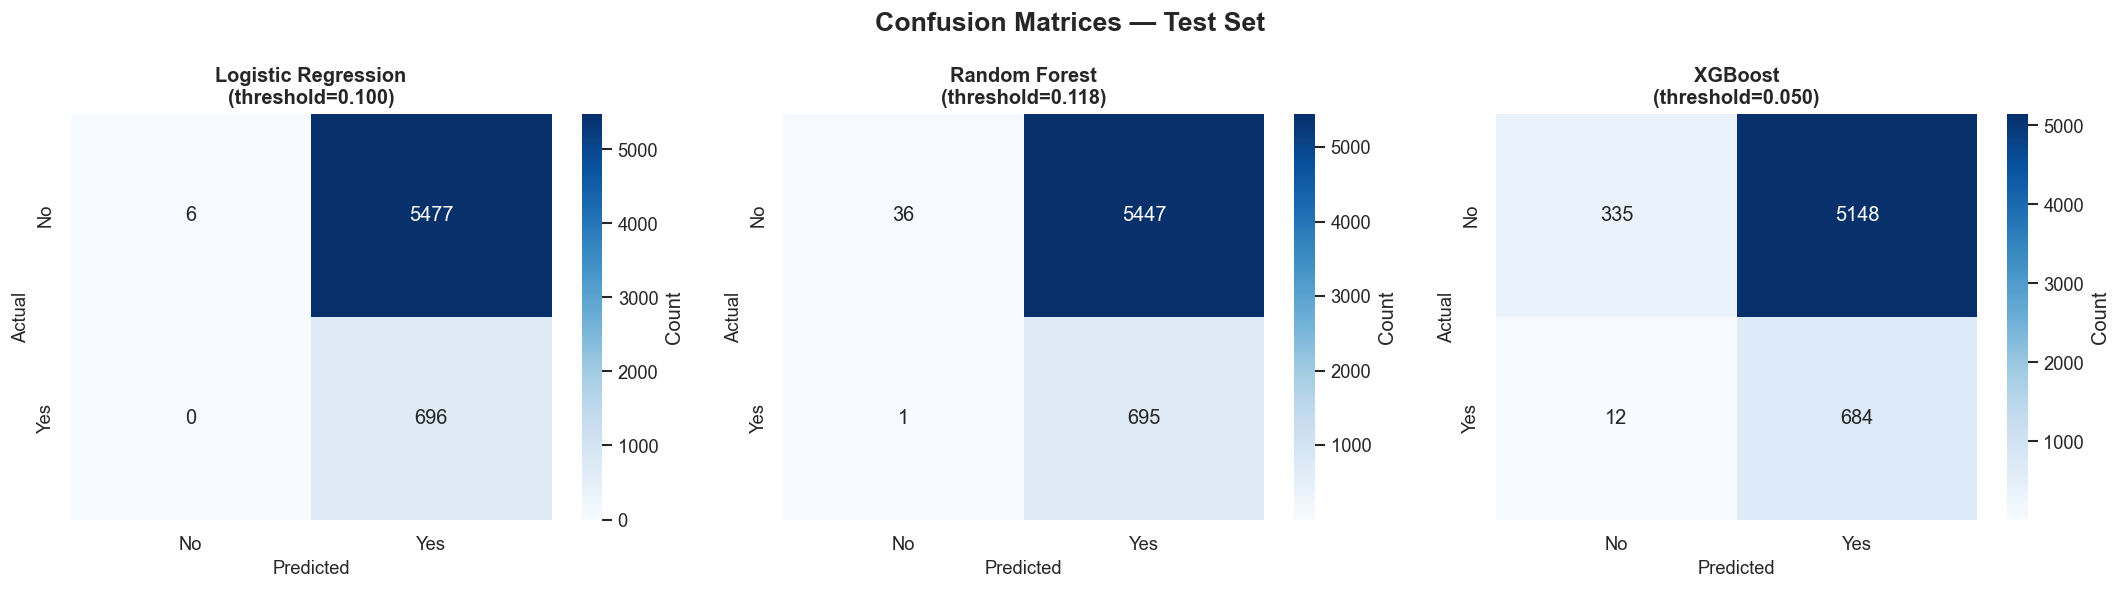

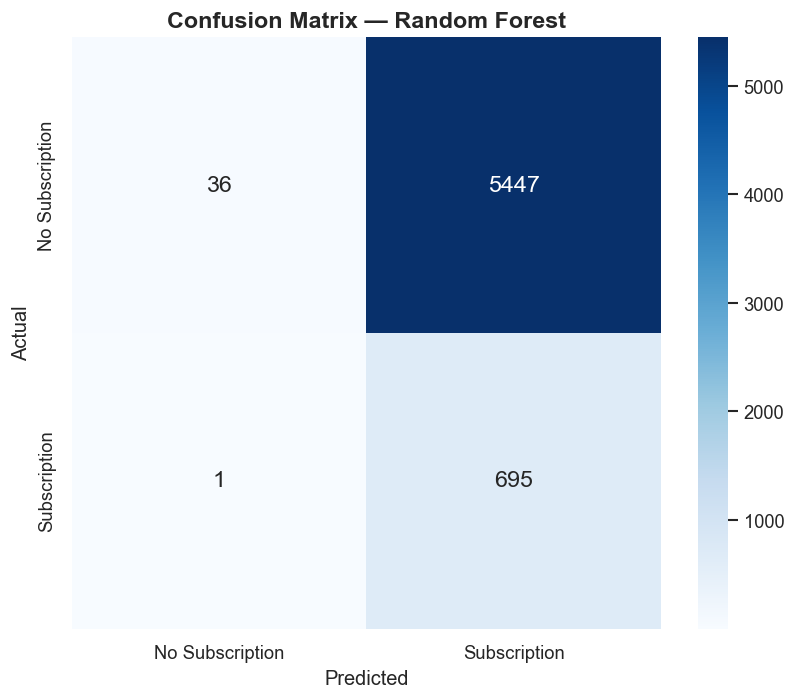

In [8]:
# === CELL 8: Confusion Matrices ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, preds) in zip(axes, test_predictions.items()):
    cm = confusion_matrix(y_test, preds["y_pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"],
                cbar_kws={"label": "Count"})
    ax.set_xlabel("Predicted", fontsize=11)
    ax.set_ylabel("Actual", fontsize=11)
    ax.set_title(f"{name}\n(threshold={thresholds[name]:.3f})", fontsize=12, fontweight="bold")

plt.suptitle("Confusion Matrices — Test Set", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrices_all.png", bbox_inches="tight")
plt.show()

# Save individual confusion matrix for best model
fig_single, ax_single = plt.subplots(figsize=(7, 6))
best_name = results_df.loc[results_df["roc_auc"].astype(float).idxmax(), "Model"]
cm_best = confusion_matrix(y_test, test_predictions[best_name]["y_pred"])
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", ax=ax_single,
            xticklabels=["No Subscription", "Subscription"],
            yticklabels=["No Subscription", "Subscription"],
            annot_kws={"size": 14})
ax_single.set_xlabel("Predicted", fontsize=12)
ax_single.set_ylabel("Actual", fontsize=12)
ax_single.set_title(f"Confusion Matrix — {best_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / f"confusion_matrix_{best_name.lower().replace(' ', '_')}.png", bbox_inches="tight")
plt.show()

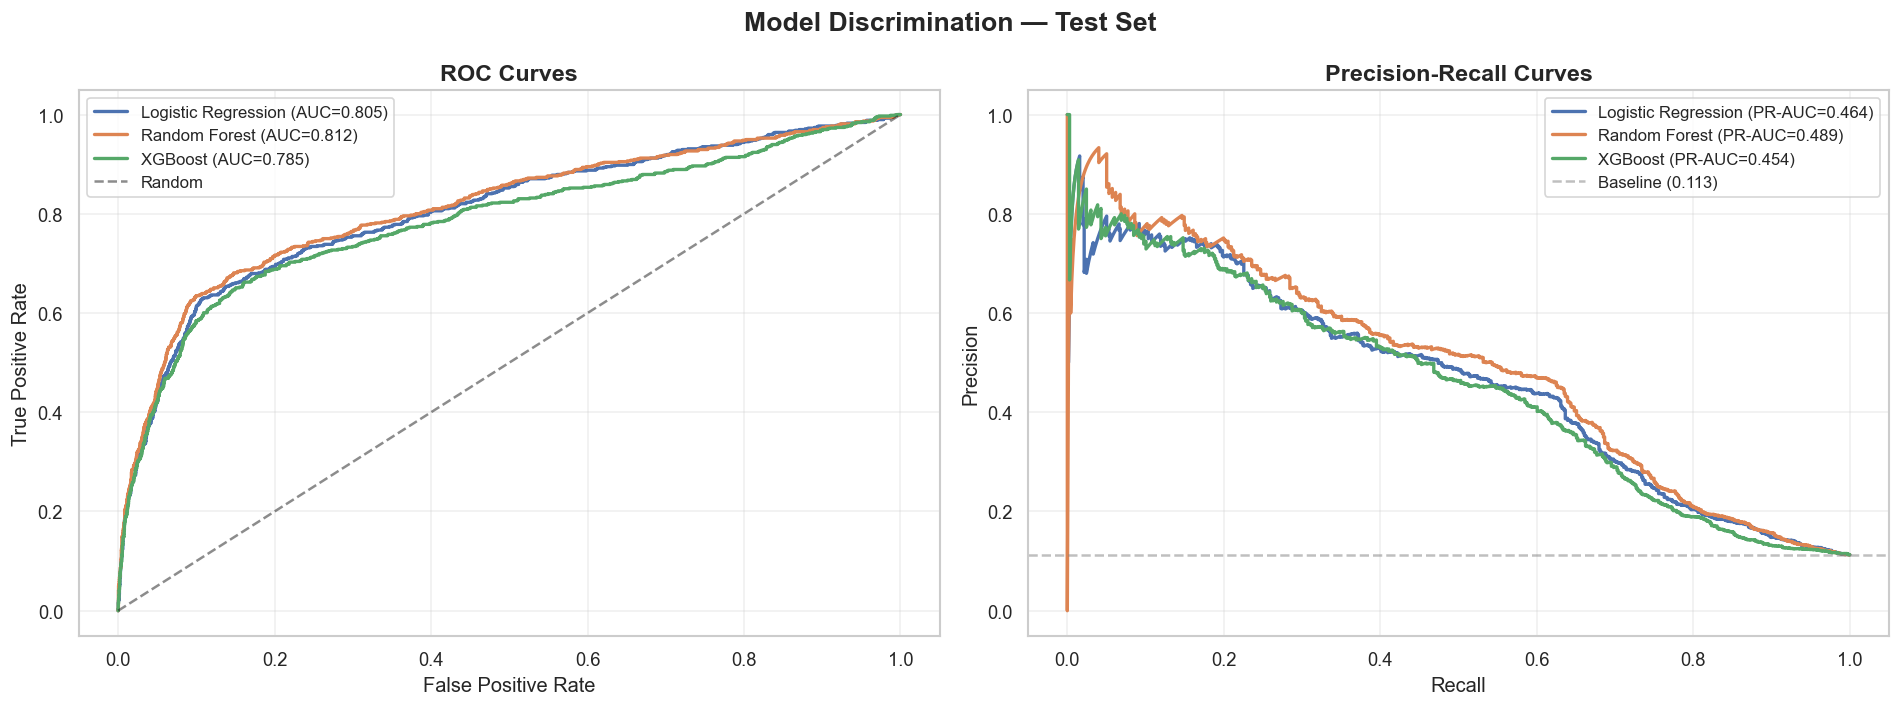

📋 NOTE: PR-AUC is the primary metric for imbalanced datasets.
   ROC-AUC can be misleadingly high when negatives dominate.


In [9]:
# === CELL 9: ROC Curves ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
ax = axes[0]
for name, preds in test_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, preds["y_prob"])
    auc_val = roc_auc_score(y_test, preds["y_prob"])
    ax.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc_val:.3f})")

ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Random")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves", fontsize=14, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Precision-Recall Curve
ax = axes[1]
for name, preds in test_predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, preds["y_prob"])
    pr_auc_val = average_precision_score(y_test, preds["y_prob"])
    ax.plot(recall, precision, linewidth=2, label=f"{name} (PR-AUC={pr_auc_val:.3f})")

# Baseline = positive class prevalence
baseline = y_test.mean()
ax.axhline(baseline, color="gray", linestyle="--", alpha=0.5, label=f"Baseline ({baseline:.3f})")
ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.set_title("Precision-Recall Curves", fontsize=14, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle("Model Discrimination — Test Set", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "roc_pr_curves.png", bbox_inches="tight")
plt.show()

print("📋 NOTE: PR-AUC is the primary metric for imbalanced datasets.")
print("   ROC-AUC can be misleadingly high when negatives dominate.")

In [10]:
# === CELL 10: Classification Reports ===
for name, preds in test_predictions.items():
    print(f"\n{'='*50}")
    print(f" CLASSIFICATION REPORT: {name}")
    print(f" Threshold: {thresholds[name]:.3f}")
    print(f"{'='*50}")
    print(classification_report(
        y_test, preds["y_pred"],
        target_names=["No Subscription", "Subscription"],
        digits=4,
    ))


 CLASSIFICATION REPORT: Logistic Regression
 Threshold: 0.100
                 precision    recall  f1-score   support

No Subscription     1.0000    0.0011    0.0022      5483
   Subscription     0.1127    1.0000    0.2026       696

       accuracy                         0.1136      6179
      macro avg     0.5564    0.5005    0.1024      6179
   weighted avg     0.9001    0.1136    0.0248      6179


 CLASSIFICATION REPORT: Random Forest
 Threshold: 0.118
                 precision    recall  f1-score   support

No Subscription     0.9730    0.0066    0.0130      5483
   Subscription     0.1132    0.9986    0.2033       696

       accuracy                         0.1183      6179
      macro avg     0.5431    0.5026    0.1082      6179
   weighted avg     0.8761    0.1183    0.0345      6179


 CLASSIFICATION REPORT: XGBoost
 Threshold: 0.050
                 precision    recall  f1-score   support

No Subscription     0.9654    0.0611    0.1149      5483
   Subscription     0.11

💰 BUSINESS IMPACT ANALYSIS
                         profit  calls  conversions  profit_per_call
Call Nobody                   0      0            0             0.00
Call Everybody           108305   6179          696            17.53
ML: Logistic Regression  108335   6173          696            17.55
ML: Random Forest        108090   6142          695            17.60
ML: XGBoost              105240   5832          684            18.05


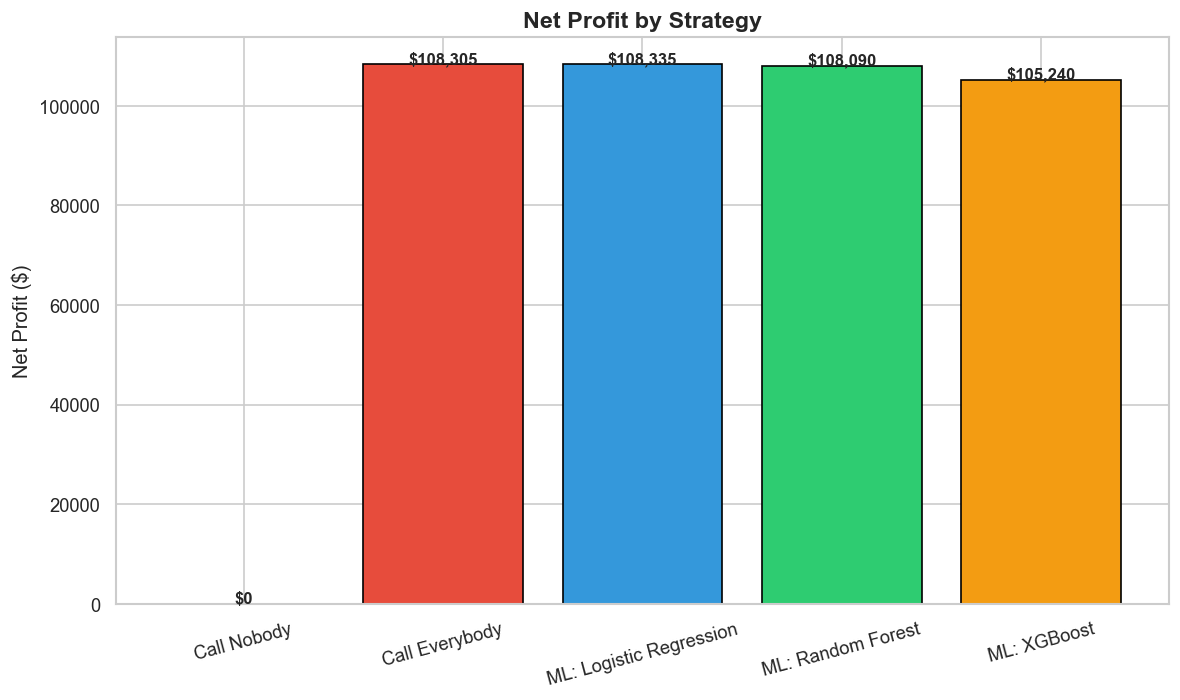

In [11]:
# === CELL 11: Business Impact Analysis ===
print("=" * 60)
print("💰 BUSINESS IMPACT ANALYSIS")
print("=" * 60)

strategies = {
    "Call Nobody": {"profit": 0, "calls": 0, "conversions": 0},
    "Call Everybody": {
        "profit": int(y_test.sum()) * 195 - int((1 - y_test).sum()) * 5,
        "calls": len(y_test),
        "conversions": int(y_test.sum()),
    },
}

for name, preds in test_predictions.items():
    cm = confusion_matrix(y_test, preds["y_pred"])
    tn, fp, fn, tp = cm.ravel()
    strategies[f"ML: {name}"] = {
        "profit": tp * 195 - fp * 5 - fn * 200,
        "calls": tp + fp,
        "conversions": tp,
    }

strategy_df = pd.DataFrame(strategies).T
strategy_df["profit_per_call"] = np.where(
    strategy_df["calls"] > 0,
    strategy_df["profit"] / strategy_df["calls"],
    0
).round(2)

print(strategy_df.to_string())

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["#95a5a6", "#e74c3c"] + ["#3498db", "#2ecc71", "#f39c12"][:len(test_predictions)]
bars = ax.bar(strategy_df.index, strategy_df["profit"], color=colors, edgecolor="black")
ax.set_ylabel("Net Profit ($)", fontsize=12)
ax.set_title("Net Profit by Strategy", fontsize=14, fontweight="bold")
ax.axhline(0, color="black", linewidth=0.5)
for bar, val in zip(bars, strategy_df["profit"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f"${val:,.0f}", ha="center", fontweight="bold", fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "business_impact.png", bbox_inches="tight")
plt.show()

HYPERPARAMETER OPTIMIZATION — Optuna (XGBoost)


  0%|          | 0/50 [00:00<?, ?it/s]


🏆 Best trial:
  AUC: 0.7982
  Params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01233075561722639, 'subsample': 0.7372343527760705, 'colsample_bytree': 0.6686463378636998, 'reg_alpha': 0.0002583320078136286, 'reg_lambda': 0.013009074722483006}


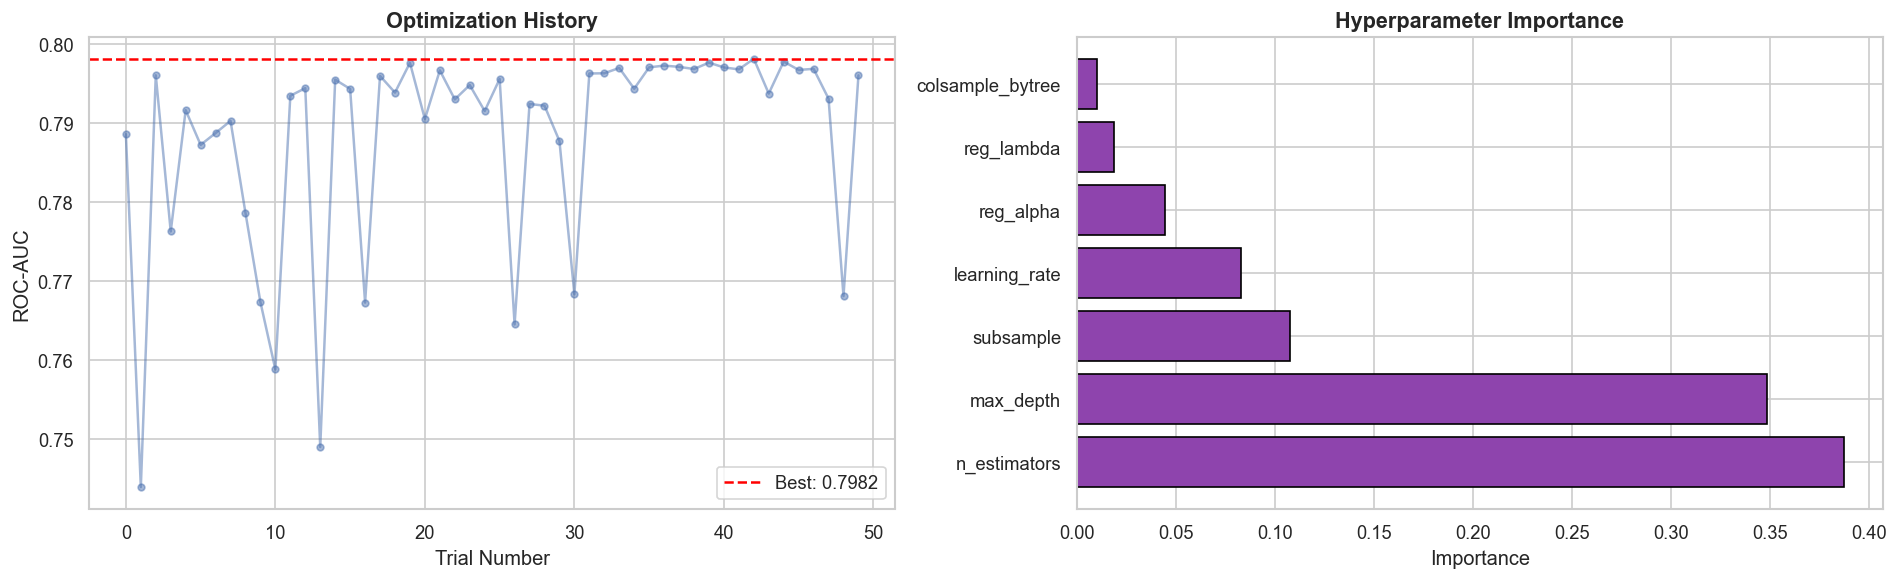

In [12]:
# === CELL 12: Hyperparameter Tuning with Optuna ===
import optuna

print("=" * 60)
print("HYPERPARAMETER OPTIMIZATION — Optuna (XGBoost)")
print("=" * 60)

optuna.logging.set_verbosity(optuna.logging.WARNING)

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": 7.9,
        "eval_metric": "aucpr",
        "random_state": 42,
        "n_jobs": -1,
    }

    pipeline = build_full_pipeline(XGBClassifier(**params))
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction="maximize", study_name="xgboost_tuning")
study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)

print(f"\n🏆 Best trial:")
print(f"  AUC: {study.best_value:.4f}")
print(f"  Params: {study.best_params}")

# Optuna visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Optimization history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df["number"], trials_df["value"], "o-", alpha=0.5, markersize=4)
axes[0].axhline(study.best_value, color="red", linestyle="--", label=f"Best: {study.best_value:.4f}")
axes[0].set_xlabel("Trial Number")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_title("Optimization History", fontsize=13, fontweight="bold")
axes[0].legend()

# Parameter importance
param_importance = optuna.importance.get_param_importances(study)
axes[1].barh(list(param_importance.keys()), list(param_importance.values()),
             color="#8e44ad", edgecolor="black")
axes[1].set_xlabel("Importance")
axes[1].set_title("Hyperparameter Importance", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "optuna_results.png", bbox_inches="tight")
plt.show()

In [13]:
# === CELL 13: Train Optimized XGBoost ===
print("=" * 60)
print("TRAINING OPTIMIZED XGBOOST")
print("=" * 60)

best_xgb_params = {
    **study.best_params,
    "scale_pos_weight": 7.9,
    "eval_metric": "aucpr",
    "random_state": 42,
    "n_jobs": -1,
}

best_pipeline = build_full_pipeline(XGBClassifier(**best_xgb_params))
best_pipeline.fit(X_train, y_train)

# Evaluate
y_test_prob_best = best_pipeline.predict_proba(X_test)[:, 1]
opt_t, _ = find_optimal_threshold(y_val, best_pipeline.predict_proba(X_val)[:, 1])
y_test_pred_best = (y_test_prob_best >= opt_t).astype(int)

best_metrics = compute_all_metrics(y_test, y_test_pred_best, y_test_prob_best)
best_cost = business_cost_analysis(y_test, y_test_pred_best)

print(f"\nOptimized XGBoost Results (threshold={opt_t:.3f}):")
for k, v in best_metrics.items():
    print(f"  {k:15s}: {v:.4f}")
print(f"  {'net_profit':15s}: ${best_cost['net_profit']:,.0f}")

TRAINING OPTIMIZED XGBOOST

Optimized XGBoost Results (threshold=0.186):
  accuracy       : 0.1325
  precision      : 0.1147
  recall         : 0.9971
  f1             : 0.2057
  f1_macro       : 0.1251
  roc_auc        : 0.8110
  pr_auc         : 0.4820
  net_profit     : $108,140


In [17]:
# === CELL 14: Save Best Model as Pickle/Joblib ===

print("=" * 60)
print("SAVING PRODUCTION MODEL")
print("=" * 60)

# Save as joblib (preferred for sklearn pipelines)
joblib_path = MODELS_DIR / "xgboost.joblib"
joblib.dump(best_pipeline, joblib_path)
print(f"✅ Saved pipeline (joblib): {joblib_path}")
print(f"   File size: {joblib_path.stat().st_size / 1024:.0f} KB")

# Also save as pickle for compatibility
import pickle
pickle_path = MODELS_DIR / "xgboost.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_pipeline, f)
print(f"✅ Saved pipeline (pickle): {pickle_path}")

# Save XGBoost booster separately
booster_path = MODELS_DIR / "xgboost_booster.bin"
classifier = best_pipeline.named_steps.get("classifier", None)
if classifier is not None and hasattr(classifier, "get_booster"):
    booster = classifier.get_booster()
    booster.save_model(str(booster_path))
    print(f"✅ Saved booster: {booster_path}")
else:
    print("⚠️ Could not find XGBoost booster in pipeline.")

# Save all models
for name, pipeline in trained_pipelines.items():
    safe_name = name.lower().replace(" ", "_")
    path = MODELS_DIR / f"{safe_name}.joblib"
    joblib.dump(pipeline, path)
    print(f"✅ Saved: {path}")

# Save threshold
threshold_data = {
    "model": "xgboost",
    "threshold": round(opt_t, 4),
    "best_params": best_xgb_params,
    "test_metrics": {k: round(v, 4) for k, v in best_metrics.items()},
}
with open(MODELS_DIR / "threshold.json", "w") as f:
    json.dump(threshold_data, f, indent=2)
print(f"✅ Saved threshold config: {MODELS_DIR / 'threshold.json'}")

# Verify loading works — restore booster after loading
loaded_pipeline = joblib.load(joblib_path)
loaded_classifier = loaded_pipeline.named_steps.get("classifier", None)
if loaded_classifier is not None and hasattr(loaded_classifier, "load_model"):
    loaded_classifier.load_model(str(booster_path))
    print("✅ Booster restored to loaded pipeline.")
else:
    print("⚠️ Could not restore booster to loaded pipeline.")

loaded_probs = loaded_pipeline.predict_proba(X_test[:5])[:, 1]
original_probs = best_pipeline.predict_proba(X_test[:5])[:, 1]
diff = np.abs(loaded_probs - original_probs)
print("Loaded probs:", loaded_probs)
print("Original probs:", original_probs)
print("Diff:", diff, "max diff:", diff.max())
if not np.allclose(loaded_probs, original_probs):
    print("❌ Model load verification FAILED — predictions do not match.")
    raise AssertionError("Loaded model doesn't match original after booster restore.")
else:
    print("\n✅ Model load verification PASSED (after booster restore)")


SAVING PRODUCTION MODEL
✅ Saved pipeline (joblib): c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\xgboost.joblib
   File size: 788 KB
✅ Saved pipeline (pickle): c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\xgboost.pkl
✅ Saved booster: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\xgboost_booster.bin
✅ Saved: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\logistic_regression.joblib
✅ Saved: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\random_forest.joblib
✅ Saved: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\xgboost.joblib
✅ Saved threshold config: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\threshold.json
✅ Booster restored to loaded pipeline.
Loaded probs: [0.32523078 0.7788803  0.28992474 0.21066521 0.3400314 ]
Original probs: [0.32523078 0.7788803  0.28992474 0.21066521 0.3400314 ]
Diff: [0. 0. 0. 0. 0.] max diff: 0.0

✅ Model load verification PASSED (after booster restore)


In [18]:
# === CELL 15: Summary ===
print("=" * 60)
print("📋 NOTEBOOK 03 SUMMARY")
print("=" * 60)
print(f"""
MODELS TRAINED: 3 (Logistic Regression, Random Forest, XGBoost)
BEST MODEL: XGBoost (Optuna-tuned, {study.best_trial.number} trials)

TEST SET RESULTS (cost-optimal threshold = {opt_t:.3f}):
  ROC-AUC:   {best_metrics['roc_auc']:.4f}
  PR-AUC:    {best_metrics['pr_auc']:.4f}
  F1:        {best_metrics['f1']:.4f}
  Precision: {best_metrics['precision']:.4f}
  Recall:    {best_metrics['recall']:.4f}
  Net Profit: ${best_cost['net_profit']:,.0f}

ARTIFACTS SAVED:
  • models/production/xgboost.joblib (production model)
  • models/production/xgboost.pkl (pickle backup)
  • models/production/threshold.json (optimal threshold + config)
  • models/production/logistic_regression.joblib
  • models/production/random_forest.joblib
  • reports/metrics/comparison.json
  • reports/figures/ (all plots)
""")

📋 NOTEBOOK 03 SUMMARY

MODELS TRAINED: 3 (Logistic Regression, Random Forest, XGBoost)
BEST MODEL: XGBoost (Optuna-tuned, 42 trials)

TEST SET RESULTS (cost-optimal threshold = 0.186):
  ROC-AUC:   0.8110
  PR-AUC:    0.4820
  F1:        0.2057
  Precision: 0.1147
  Recall:    0.9971
  Net Profit: $108,140

ARTIFACTS SAVED:
  • models/production/xgboost.joblib (production model)
  • models/production/xgboost.pkl (pickle backup)
  • models/production/threshold.json (optimal threshold + config)
  • models/production/logistic_regression.joblib
  • models/production/random_forest.joblib
  • reports/metrics/comparison.json
  • reports/figures/ (all plots)

